<a href="https://colab.research.google.com/github/amruthaduvvuri/RFM_Analysis/blob/main/RFM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
data = pd.read_csv("/content/rfm_data (2).csv")
print(data.head())

   CustomerID PurchaseDate  TransactionAmount ProductInformation  OrderID  \
0        8814   2023-04-11             943.31          Product C   890075   
1        2188   2023-04-11             463.70          Product A   176819   
2        4608   2023-04-11              80.28          Product A   340062   
3        2559   2023-04-11             221.29          Product A   239145   
4        9482   2023-04-11             739.56          Product A   194545   

   Location  
0     Tokyo  
1    London  
2  New York  
3    London  
4     Paris  


EDA

In [4]:
# shape of the dataset
print(f"Rows: {data.shape[0]}, Columns: {data.shape[1]}")
data.info()
data.isnull().sum()

Rows: 1000, Columns: 6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


,0
CustomerID,0
PurchaseDate,0
TransactionAmount,0
ProductInformation,0
OrderID,0
Location,0


Calculating RFM values

In [18]:
import datetime as dt

# Load your CSV
rfm_df = pd.read_csv("/content/rfm_data (2).csv")  # Rename to match your file

# Convert PurchaseDate to datetime
rfm_df['PurchaseDate'] = pd.to_datetime(rfm_df['PurchaseDate'])

# Set a reference date (typically one day after the latest transaction)
reference_date = rfm_df['PurchaseDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and calculate RFM values
rfm = rfm_df.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (reference_date - x.max()).days,   # Recency
    'OrderID': 'nunique',                                        # Frequency
    'TransactionAmount': 'sum'                                   # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# View the output
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0        1011       34          2   1129.02
1        1025       22          1    359.29
2        1029        1          1    704.99
3        1046       44          1    859.82
4        1049       14          1    225.72


Using K-Means clustering to segment customers based on their Recency, Frequency, and Monetary values into meaningful groups.

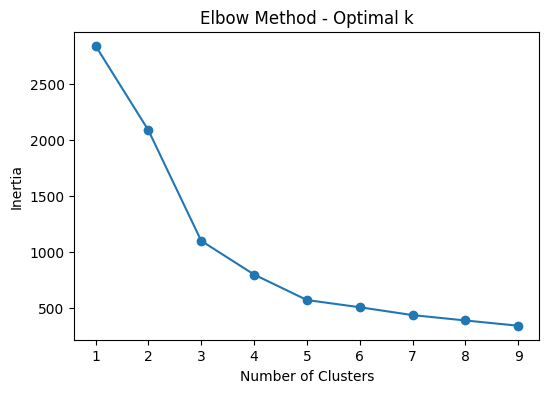

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select RFM values
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# 2. Normalize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# 3. Optional: Elbow Method to find best k
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


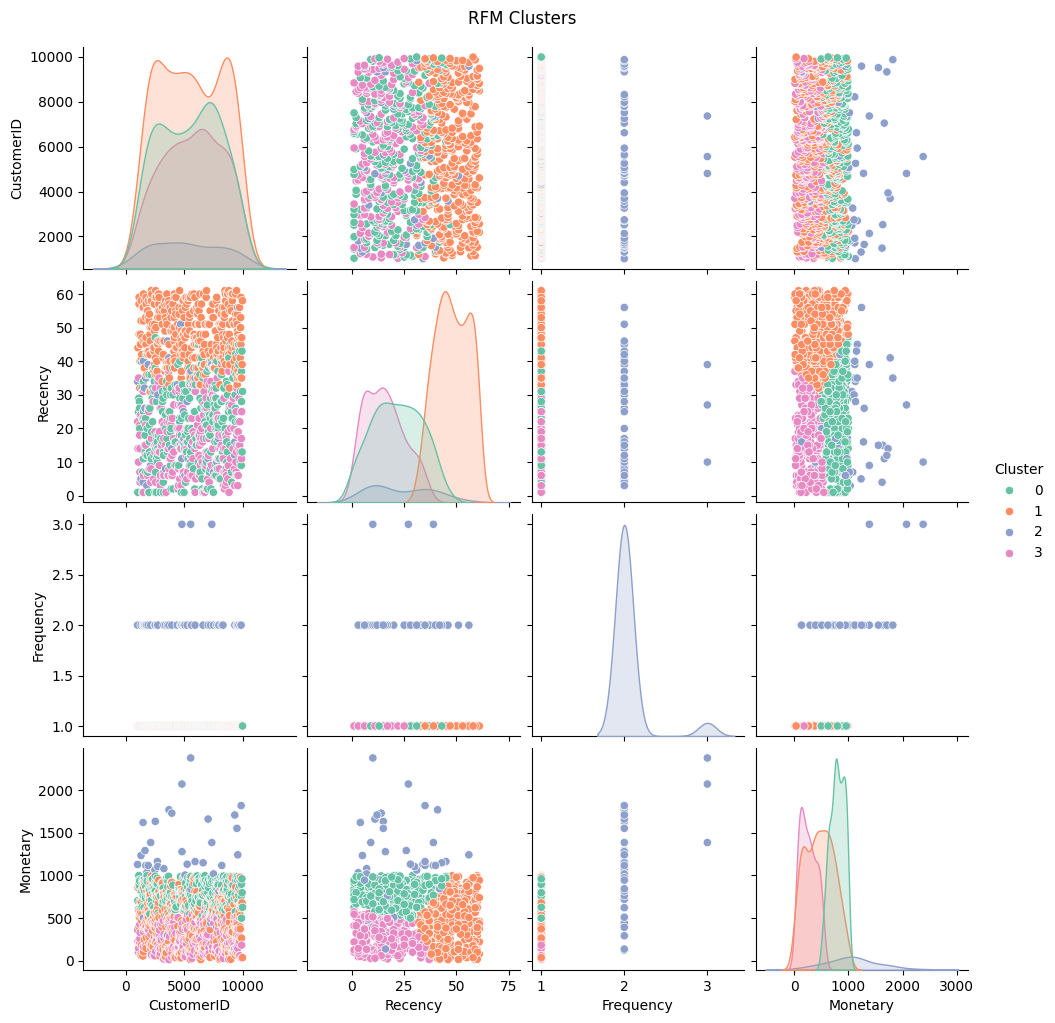

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,5487.634058,21.597826,1.000000,792.123297
1,5575.816062,47.917098,1.000000,465.996554
2,5322.039216,23.686275,2.058824,1072.476078
3,5696.845494,15.643777,1.000000,259.574378


In [7]:
# 4. Apply K-Means with chosen k
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 5. Visualize the clusters
sns.pairplot(rfm, hue='Cluster', palette='Set2')
plt.suptitle('RFM Clusters', y=1.02)
plt.show()

# 6. View cluster centers
rfm.groupby('Cluster').mean()


Creating a summary table

In [8]:
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         21.60      1.00   792.12   276
1         47.92      1.00   466.00   386
2         23.69      2.06  1072.48    51
3         15.64      1.00   259.57   233


## 🔍 Key Insights by Cluster

---

### 🔹 **Cluster 2: High-Value Champions (only 8% of users)**
- **Most frequent (2.06 purchases)** and **highest spenders ($1072 avg)**.
- **Relatively recent (23.69 days)**.
- **Only 51 customers — but they punch above their weight**.
- 🔥 **Insight**: This small group brings high revenue. Losing them would be costly.
- ✅ **Action**: Prioritize retention via **VIP loyalty**, **exclusive access**, or **thank-you perks**.

---

### 🔹 **Cluster 0: Medium-High Value Customers**
- Good spenders ($792) with moderate recency (21.60).
- Low frequency (1 purchase).
- Large segment size (276 customers).
- 💡 **Insight**: Likely new or occasional high-value customers.
- 📌 **Action**: Convert them into repeat buyers via **follow-up emails**, **targeted upselling**, or **reminder nudges**.

---

### 🔹 **Cluster 1: At-Risk or One-Time Buyers**
- **Oldest recency** (47.92 days ago) and low spend ($466).
- Largest segment (386 customers).
- ⚠️ **Insight**: One-time or lapsed customers — biggest churn risk.
- 🚨 **Action**: **Reactivation campaigns**, surveys, or **incentives to return** (e.g. “We miss you” offer).

---

### 🔹 **Cluster 3: Low-Spend Recent Buyers**
- **Most recent (15.64)** but **lowest spend ($259)**.
- Newest, possibly **trial users or discount shoppers**.
- ❓ **Insight**: New users yet to be nurtured into regular customers.
- 🌱 **Action**: Use **onboarding flows**, product recommendations, or **subscription nudges**.

---

## 🧠 Big Picture Takeaways

- The **top 8% (Cluster 2)** drive the most value — but need nurturing to avoid churn.
- Nearly **60% of customers (Clusters 1 + 3)** are **low-frequency**, **low-spend** — need re-engagement or onboarding strategies.
- **Converting even 10–15% of Cluster 0 into loyal buyers** could significantly boost revenue.

---


In [26]:
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


<ipython-input-31-bd725b63ad14>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Recency', data=rfm, palette='Set1')
<ipython-input-31-bd725b63ad14>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Frequency', data=rfm, palette='Set1')
<ipython-input-31-bd725b63ad14>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Monetary', data=rfm, palette='Set1')


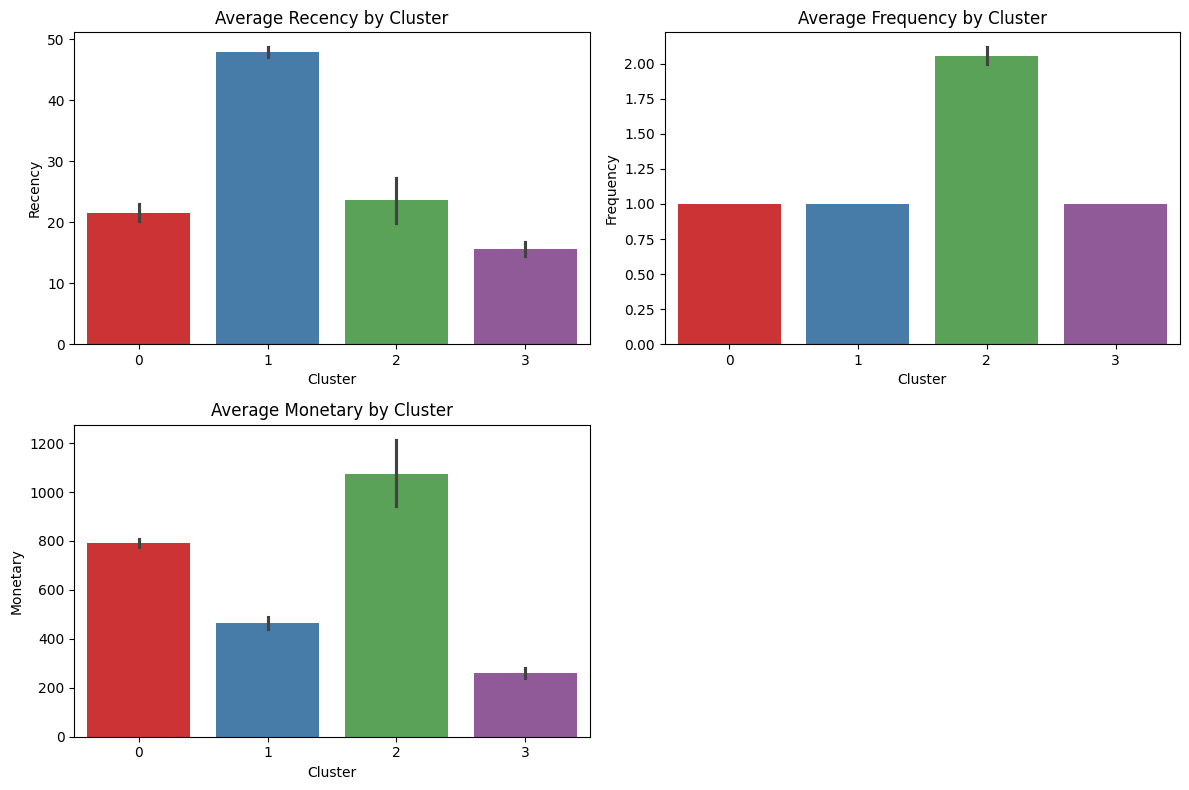

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot for Recency
plt.subplot(2, 2, 1)
sns.barplot(x='Cluster', y='Recency', data=rfm, palette='Set1')
plt.title('Average Recency by Cluster')

# Plot for Frequency
plt.subplot(2, 2, 2)
sns.barplot(x='Cluster', y='Frequency', data=rfm, palette='Set1')
plt.title('Average Frequency by Cluster')

# Plot for Monetary
plt.subplot(2, 2, 3)
sns.barplot(x='Cluster', y='Monetary', data=rfm, palette='Set1')
plt.title('Average Monetary by Cluster')

plt.tight_layout()
plt.show()



These bar plots help to understand the average values of Recency, Frequency, and Monetary by cluster. This gives a quick overview of the clusters' characteristics.

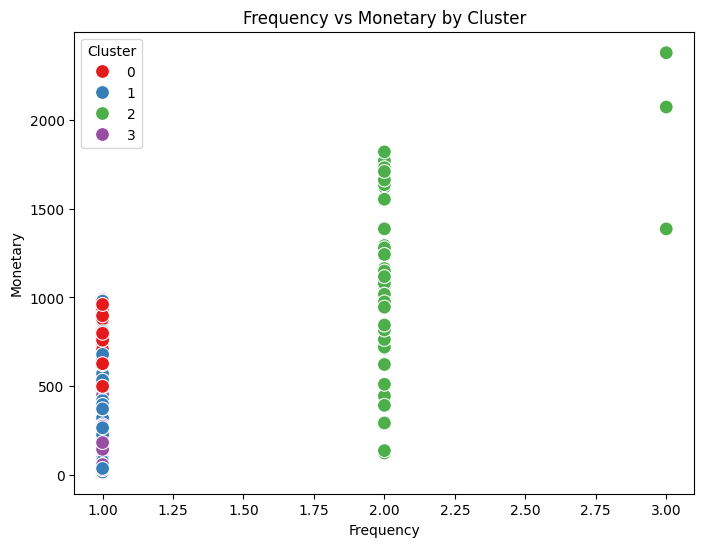

In [30]:
# Scatter Plot for Frequency vs Monetary, colored by Cluster

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set1', s=100, markers=["o", "s", "D", "v"])
plt.title('Frequency vs Monetary by Cluster')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()


A scatter plot that plots Frequency on the x-axis and Monetary on the y-axis. The points are colored according to the cluster they belong to, which helps visualize how different clusters perform on these two key dimensions.

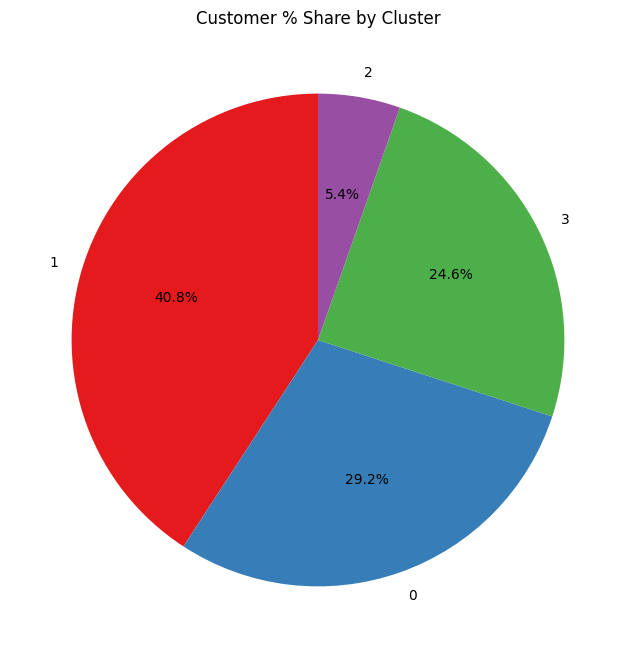

In [32]:
#Pie/Donut Chart for Customer % Share by Cluster

cluster_counts = rfm['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Customer Count']

# Plotting the Pie chart
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts['Customer Count'], labels=cluster_counts['Cluster'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set1", len(cluster_counts)))
plt.title('Customer % Share by Cluster')
plt.show()

\
The Pie/Donut Chart provides a clear picture of which clusters have the highest customer share, helping prioritize segments